In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [54]:
# 1. Carga de datos
archivo_csv = "datos_procesados.csv"  # Asegúrate de que el archivo está en la ruta correcta
df = pd.read_csv(r"/Users/alejandrabenavidessanclemente/Desktop/ProyectoGradoGEB/ProyectoGradoGEB/datos_procesados.csv")

In [55]:
# 2. Definir X y Y
X = df[['ORIG_STD_VOLUME', 'STD_VOLUME', 'ORIG_TEMPERATURE', 'TEMPERATURE', 
        'PRESSURE', 'ORIG_PRESSURE', 'ORIG_RAW_VOLUME', 'RAW_VOLUME']]
y = (df['STD_VOLUME'] > df['STD_VOLUME'].quantile(0.95)).astype(int)  # 1 = anomalía, 0 = normal

In [56]:
# 3. Normalizar X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [58]:
# 4. Verificar la importancia de variables
modelo_base = LogisticRegression(max_iter=500, solver='liblinear')  # Asegurar un solver adecuado
modelo_base.fit(X_scaled, y)
importancia = abs(modelo_base.coef_).ravel()  # Asegurar que es un array unidimensional
variables = X.columns

# Crear DataFrame con importancia
importancia_df = pd.DataFrame({'Variable': variables, 'Importancia': importancia})
importancia_df = importancia_df.sort_values(by="Importancia", ascending=False)

print("\n📊 Importancia de variables:\n", importancia_df)



📊 Importancia de variables:
            Variable  Importancia
1        STD_VOLUME    12.741935
0   ORIG_STD_VOLUME    12.624214
7        RAW_VOLUME     0.855133
4          PRESSURE     0.799046
5     ORIG_PRESSURE     0.799046
6   ORIG_RAW_VOLUME     0.631969
2  ORIG_TEMPERATURE     0.007454
3       TEMPERATURE     0.007454


In [59]:
# 5. Eliminar las variables con baja importancia (< 0.5)
umbral = 0.5  # Umbral de importancia mínima
variables_importantes = importancia_df[importancia_df['Importancia'] > umbral]['Variable'].tolist()
X = df[variables_importantes]

print(f"\n🔹 Variables seleccionadas: {variables_importantes}")


🔹 Variables seleccionadas: ['STD_VOLUME', 'ORIG_STD_VOLUME', 'RAW_VOLUME', 'PRESSURE', 'ORIG_PRESSURE', 'ORIG_RAW_VOLUME']


In [60]:
# 6️. Volver a normalizar con solo las variables necesarias
X_scaled = scaler.fit_transform(X)

In [61]:
# 7️. Selección Automática de Variables con RFE
modelo_rfe = LogisticRegression(max_iter=500, solver='liblinear')
rfe = RFE(modelo_rfe, n_features_to_select=5)  # Selecciona las 5 más importantes
rfe.fit(X_scaled, y)

mejores_variables = X.columns[rfe.support_]
print("\n🔍 Mejores variables tras RFE:", mejores_variables)


🔍 Mejores variables tras RFE: Index(['STD_VOLUME', 'ORIG_STD_VOLUME', 'RAW_VOLUME', 'PRESSURE',
       'ORIG_PRESSURE'],
      dtype='object')


In [ ]:
# 8️. Optimización de Hiperparámetros con Randomized Search
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    'C': np.logspace(-2, 1, 10),  # 10 valores en escala logarítmica
    'penalty': ['l1', 'l2'],  # Penalización
    'solver': ['liblinear'],  # Solver rápido
}

random_search = RandomizedSearchCV(
    LogisticRegression(max_iter=500), param_distributions=param_dist, 
    cv=3, scoring="accuracy", n_iter=10, n_jobs=-1, random_state=42
)

random_search.fit(X_scaled[:, rfe.support_], y)

print("\n✅ Mejores parámetros encontrados:", random_search.best_params_)


✅ Mejores parámetros encontrados: {'solver': 'liblinear', 'penalty': 'l1', 'C': 10.0}


In [71]:
# 9️. Entrenar el modelo final con los mejores parámetros
mejor_modelo = LogisticRegression(**random_search.best_params_)
mejor_modelo.fit(X_scaled[:, rfe.support_], y)

/Users/alejandrabenavidessanclemente/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LogisticRegression(C=10.0, penalty='l1', solver='liblinear')

In [72]:
# 10. Evaluación con Validación Cruzada**
scores = cross_val_score(mejor_modelo, X_scaled[:, rfe.support_], y, cv=5, scoring='accuracy')

print("\n📈 Accuracy promedio:", scores.mean())
print("📊 Accuracy en cada fold:", scores)

/Users/alejandrabenavidessanclemente/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/alejandrabenavidessanclemente/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/alejandrabenavidessanclemente/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/alejandrabenavidessanclemente/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(



📈 Accuracy promedio: 0.997136294027565
📊 Accuracy en cada fold: [0.99820061 0.99900459 0.99758806 0.99330015 0.99758806]


/Users/alejandrabenavidessanclemente/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [73]:
# 1️1. Matriz de Confusión y Reporte de Clasificación**
y_pred = mejor_modelo.predict(X_scaled[:, rfe.support_])
print("\n🎯 Matriz de Confusión:")
print(confusion_matrix(y, y_pred))

print("\n📋 Reporte de Clasificación:")
print(classification_report(y, y_pred))


🎯 Matriz de Confusión:
[[124060     13]
 [    22   6505]]

📋 Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    124073
           1       1.00      1.00      1.00      6527

    accuracy                           1.00    130600
   macro avg       1.00      1.00      1.00    130600
weighted avg       1.00      1.00      1.00    130600



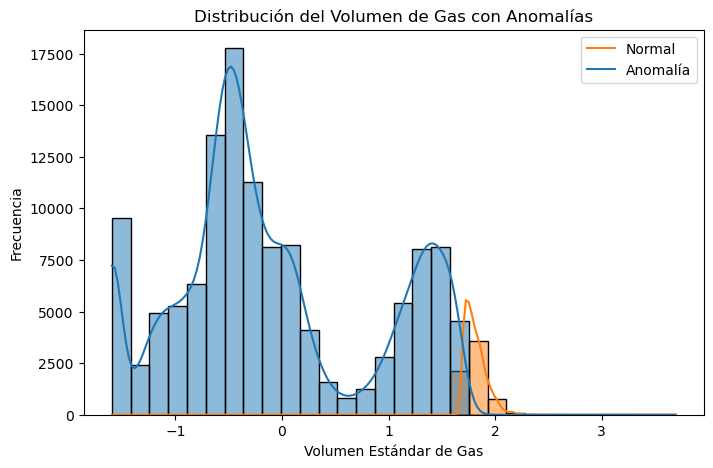

In [74]:
# 1️2. Visualización de la Distribución de Anomalías**
plt.figure(figsize=(8, 5))
sns.histplot(df, x="STD_VOLUME", hue=y, bins=30, kde=True)
plt.title("Distribución del Volumen de Gas con Anomalías")
plt.xlabel("Volumen Estándar de Gas")
plt.ylabel("Frecuencia")
plt.legend(["Normal", "Anomalía"])
plt.show()